In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import math
import cv2
import torch.distributions as td

In [2]:
random_seed = 111

In [3]:
origin_dataset = torch.load('moving_minst_data.pt')


In [4]:
m=len(origin_dataset)
train_data, val_data, test_data = origin_dataset[:int(m*0.6)], origin_dataset[int(m*0.6):int(m*0.8)],origin_dataset[int(m*0.8):]

batch_size=128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [5]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size, stride, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size, stride, padding=1)
        self.batch2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size, stride, padding=1)  
        self.conv4 = nn.Conv2d(64, 128, kernel_size, stride, padding=1)
        self.batch3 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size, stride, padding=1)
        self.linear1 = nn.Linear(256*2*2, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = td.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
        
    def forward(self, x):
        x = x.to(device)


        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        
        x = F.relu(self.batch3(self.conv4(x)))
        x = F.relu(self.conv5(x))
      
        x = torch.flatten(x, start_dim=1)
        
        x = F.relu(self.linear1(x))

        mu =  self.linear2(x)
        log_var = self.linear3(x)
        sigma = torch.exp(0.5 * log_var)
        
        rand_state = torch.random.get_rng_state()[0]
        torch.random.manual_seed(rand_state+1)
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl=-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(),dim=1)
        # self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z   
    

In [6]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 256*2*2),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, 2, 2))

        self.decoder_conv = nn.Sequential(

            nn.ConvTranspose2d(256, 128, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size, stride, padding=1, output_padding=1),
            nn.Upsample(size=(64,64))
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        
        x = torch.sigmoid(x)
        return x


In [7]:
class GaussianDecoder(Decoder):
    def forward(self, x):
        x = self.decoder_lin(x)
        
        x = self.unflatten(x)
        x = self.decoder_conv(x)

        x = torch.sigmoid(x)
       
        var = torch.ones_like(x)
        
        return td.Normal(loc=x, scale=var)

In [8]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = GaussianDecoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [9]:
### Set the random seed for reproducible results
torch.manual_seed(random_seed)

kernel_size = [3,3]
stride=[2,2]

d = 11

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)


criterion = nn.BCELoss(reduction='sum')

Selected device: cuda


In [10]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    nll_loss = 0.0
    kl_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for data in dataloader: 
        # Move tensor to the proper device
   
        x = data.to(device)
       
        x_hat = vae(x).mean
        
        # Evaluate loss
        # if all zero in a mask, change back to 1
       

    
      

        nll = ((x_hat-x)**2).sum()

        kl = vae.encoder.kl.mean()

        loss = nll + kl*0.1
        # loss = ((x - x_hat)**2).sum() + vae.encoder.kl
      
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.item()))
        nll_loss += nll.item()
        kl_loss += kl.item()

        train_loss+=loss.item()
        

    return train_loss / len(dataloader), nll_loss / len(dataloader), kl_loss / len(dataloader)

In [11]:
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    nll_loss = 0.0
    kl_loss = 0.0
    bce_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for data in dataloader:
            # Move tensor to the proper device
           
            x = data.to(device)
           
            x_hat = vae(x).mean
        


            # temp_mask = mask.squeeze().flatten(1,2)
            # mask_sum = temp_mask.sum(1)
            # boolen_mask = (mask_sum ==0)
            # temp_mask[boolen_mask] = 1
            # temp_mask = temp_mask.reshape(mask.shape)
           
            # Encode data
            # encoded_data = vae.encoder(x)
            # decoded_data = vae.decoder(encoded_data)
            # print(decoded_data.size())
            # Decode data
            
        # Evaluate loss
            
            nll = ((x_hat-x)**2).sum()

            kl = vae.encoder.kl.mean()

            loss = nll + kl*0.1
            
            
            # loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            nll_loss += nll.item()
            kl_loss += kl.item()

          
            val_loss += loss.item()

            bce_loss += criterion(x_hat.flatten(),x.flatten()).item()

    return val_loss / len(dataloader), nll_loss / len(dataloader), kl_loss / len(dataloader), bce_loss/len(dataloader)

In [12]:
def plot_ae_outputs(encoder,decoder,n=10):
    fig, axs = plt.subplots(10, 2,figsize=(30,100))
    # targets = [item[0] for item in test_data]
    # t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    i=0
    random.seed(random_seed)
    for index in random.sample(range(len(test_data)), n):
      img = test_data[index][:1].unsqueeze(0).to(device)
      
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img)).mean
      axs[i,0].imshow(img.cpu().squeeze().numpy(), cmap='gray')
     
      axs[i,1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray')
      i=i+1

In [13]:
num_epochs = 100

train_loss_sum = []
train_nll_sum = []
train_kl_sum = []
val_loss_sum = []
val_nll_sum = []
val_kl_sum = []
for epoch in range(num_epochs):
   train_loss,train_nll_loss,train_kl_loss = train_epoch(vae,device,train_loader,optim)
   val_loss,val_nll_loss,val_kl_loss,bce_loss = test_epoch(vae,device,valid_loader)
   train_loss_sum.append(train_loss)
   train_nll_sum.append(train_nll_loss)
   train_kl_sum.append(train_kl_loss)
   val_loss_sum.append(val_loss)
   val_nll_sum.append(val_nll_loss)
   val_kl_sum.append(val_kl_loss)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t train nll loss {:.3f} \t train kl loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,train_nll_loss,train_kl_loss))
   print('\n val loss {:.3f} \t val nll loss {:.3f} \t val kl loss {:.3f} \t bce loss {:.3f}'.format(val_loss,val_nll_loss,val_kl_loss,bce_loss))
   # plot_ae_outputs(vae.encoder,vae.decoder,n=10)


 EPOCH 1/100 	 train loss 63048.138 	 train nll loss 63028.273 	 train kl loss 198.642

 val loss 47019.378 	 val nll loss 47015.260 	 val kl loss 41.178 	 bce loss 189648.578

 EPOCH 2/100 	 train loss 37590.830 	 train nll loss 37586.462 	 train kl loss 43.676

 val loss 30169.822 	 val nll loss 30163.276 	 val kl loss 65.457 	 bce loss 139716.221

 EPOCH 3/100 	 train loss 26437.369 	 train nll loss 26431.778 	 train kl loss 55.916

 val loss 21436.106 	 val nll loss 21427.997 	 val kl loss 81.094 	 bce loss 107958.253

 EPOCH 4/100 	 train loss 20172.082 	 train nll loss 20165.975 	 train kl loss 61.072

 val loss 17797.140 	 val nll loss 17790.669 	 val kl loss 64.710 	 bce loss 93489.475

 EPOCH 5/100 	 train loss 16912.649 	 train nll loss 16906.219 	 train kl loss 64.303

 val loss 15341.637 	 val nll loss 15334.649 	 val kl loss 69.883 	 bce loss 82726.314

 EPOCH 6/100 	 train loss 14711.365 	 train nll loss 14704.402 	 train kl loss 69.628

 val loss 13705.769 	 val nll los

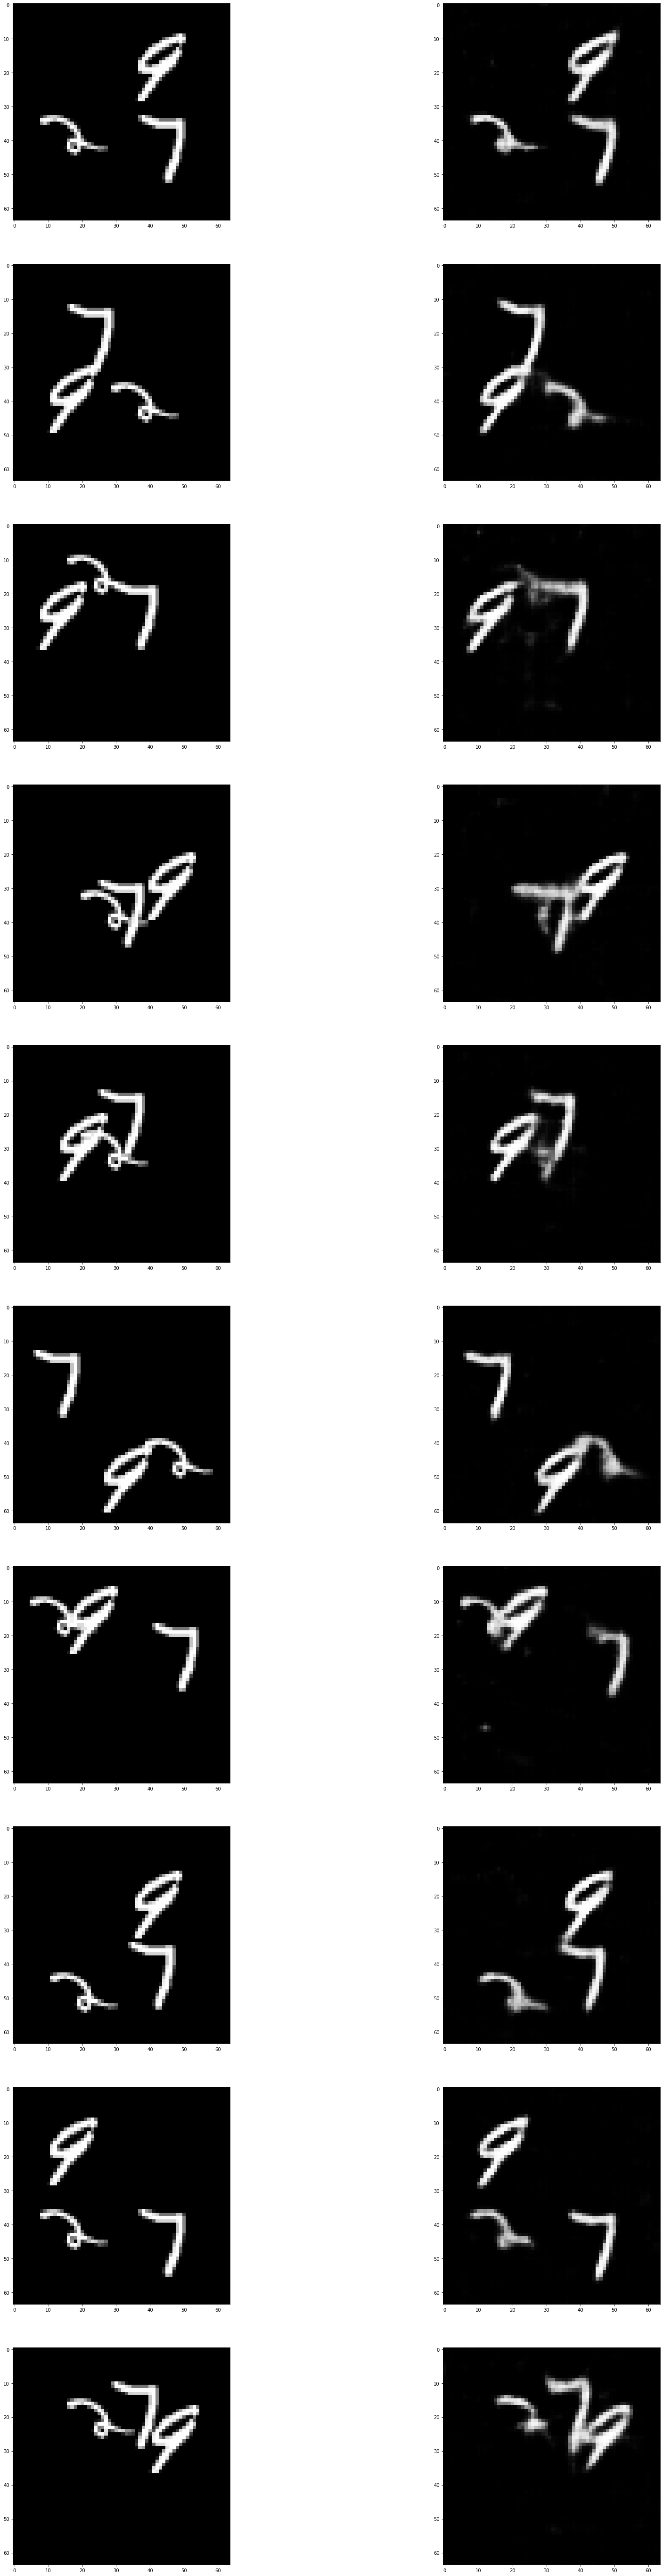

In [14]:
plot_ae_outputs(vae.encoder,vae.decoder,n=10)

In [15]:
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)


batch_size = 100
epochs = 100
seqlen = 8

z_size = d
n_hidden = 256
n_gaussians = 20

In [16]:
def ToSeqData(dataset, seqlen):
    dataset_seq=[]

    for i in range(0,len(dataset)-(len(dataset)%seqlen),seqlen):
      
        dataset_seq.append(dataset[i:i+seqlen, :])
       
    dataset_seq=torch.stack(dataset_seq, dim=0)
    return dataset_seq

In [17]:
train_dataset = ToSeqData(train_data,seqlen)
val_dataset = ToSeqData(val_data,seqlen)
test_dataset =ToSeqData(test_data,seqlen)

In [18]:
batch_size=50

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)


criterion = nn.BCELoss(reduction='sum')

In [19]:
class MDNRNN(nn.Module):
    def __init__(self, z_size, n_hidden=256, n_gaussians=10, n_layers=1,direction='forward'):
        super(MDNRNN, self).__init__()

        self.z_size = z_size
        self.n_hidden = n_hidden
        self.n_gaussians = n_gaussians
        self.n_layers = n_layers
        self.direction = direction
        
        self.lstm_cell = nn.LSTMCell(z_size,n_hidden)
        self.lstm = nn.LSTM(z_size, n_hidden, n_layers, batch_first=True)
        self.fc1 = nn.Linear(n_hidden, n_gaussians*z_size)
        self.fc2 = nn.Linear(n_hidden, n_gaussians*z_size)
        self.fc3 = nn.Linear(n_hidden, n_gaussians*z_size)
        
    def get_mixture_coef(self, y):
        pi, mu, sigma = self.fc1(y), self.fc2(y), self.fc3(y)
     
        pi = pi.view(-1, self.n_gaussians, self.z_size)
        mu = mu.view(-1, self.n_gaussians, self.z_size)
        sigma = sigma.view(-1, self.n_gaussians, self.z_size)
        
        pi = F.softmax(pi, 1)
        sigma = torch.exp(sigma)
        sigma = abs(sigma)
        return pi, mu, sigma
        
        
    def forward(self, data ,direct=None):

        if not direct:
            direct = self.direction
        
        if direct == "backward":
            data = data.flip(1)
       
        
        input_d = data[:,:,0,:,:] #size(10,6,64,64)
        input_m = data[:,:,1,:,:]

        output_pi = []
        output_mu = []
        output_sigma = []

        predict_result = []
        imputed_result = []
        latent_result = []
       
        h_c = (torch.zeros(data.size(0), self.n_hidden).to(device),
                torch.zeros(data.size(0), self.n_hidden).to(device))

        for t in range(input_d.size(1)):
            # get predict img by hidden
            h,_ = h_c
           
            pi, mu, sigma = self.get_mixture_coef(h)

            output_pi.append(pi)
            output_mu.append(mu)
            output_sigma.append(sigma)
          
            pi = pi.unsqueeze(1)
            mu = mu.unsqueeze(1)
            sigma = sigma.unsqueeze(1)
            
      
           
            # pi_t=pi.transpose(2, 3)
            # pi_t_r=pi_t.reshape(pi_t.size(0)*pi_t.size(1)*pi_t.size(2),pi_t.size(3))

            # rand_state = torch.random.get_rng_state()[0]
            

            # k = torch.multinomial(pi_t_r, 1).view(-1)
            
            # k_r = k.reshape(pi_t.size(0),pi_t.size(1),pi_t.size(2)).unsqueeze(2)

       
            # preds = torch.normal(mu, sigma).gather(2,k_r).squeeze(2).squeeze(1)

            preds = torch.sum((torch.normal(mu, sigma)*pi),dim=2).squeeze(1)
            preds_img = vae.decoder(preds).mean
                
            
            predict_result.append(preds_img)
            # combine input image and predict image
            input_t = input_d[:,t,:,:].unsqueeze(1)
            m = input_m[:,t,:,:].unsqueeze(1)
            input_c = input_t*m+preds_img*(1-m)
            imputed_result.append(input_c)
            # Get latent dimension by vae
           
            x = vae.encoder(input_c)

            latent_result.append(x)
            h_c = self.lstm_cell(x,h_c)
            
           

        # predict next image use for imputation next target

      
       
        pi_t = torch.stack(output_pi, dim=1)
        mu_t = torch.stack(output_mu, dim=1)
        sigma_t = torch.stack(output_sigma, dim=1)
        imputations = torch.stack(imputed_result, dim=1)
        predicts= torch.stack(predict_result, dim=1)
        latents = torch.stack(latent_result, dim=1).unsqueeze(2)
        if direct == "backward":
            pi_t=pi_t.flip(1)
            mu_t=mu_t.flip(1)
            sigma_t=sigma_t.flip(1)
            imputations=imputations.flip(1)
            predicts=predicts.flip(1)
            latents = latents.flip(1)
        return (pi_t,mu_t,sigma_t),predicts,imputations,latents


In [20]:
model = MDNRNN(z_size, n_hidden,n_gaussians).to(device)

In [21]:
def weighted_logsumexp(x,w, dim=None, keepdim=False):
    if dim is None:
        x, dim = x.view(-1), 0
    xm, _ = torch.max(x, dim, keepdim=True)
    x = torch.where(
        # to prevent nasty nan's
        (xm == float('inf')) | (xm == float('-inf')),
        xm,
        xm + torch.log(torch.sum(torch.exp(x - xm)*w, dim, keepdim=True)))
    return x if keepdim else x.squeeze(dim)

In [22]:
def mdn_loss_stable(y,pi,mu,sigma):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    m_lp_y = m.log_prob(y)
    loss = -weighted_logsumexp(m_lp_y,pi,dim=2)
    return loss.mean()

In [23]:
def mdn_loss_fn(y, pi, mu, sigma):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(y))
    loss = torch.sum(loss * pi, dim=2)
    loss = -torch.log(loss)
    return loss.mean()

In [24]:
optimizer = torch.optim.Adam(model.parameters())

In [25]:
for epoch in range(100):
    # Set initial hidden and cell states
    train_loss = 0
    prediction_loss = 0
    imputation_loss = 0
    
    for x in train_loader:
        x = x.to(device)
    
        optimizer.zero_grad()
        # Get mini-batch inputs and targets
        masks = torch.ones(x.shape).to(device)

        inputs = torch.cat((x,masks),dim=2).to(device)
       
        # Forward pass
        (pi, mu, sigma),predict, imputation,latents = model(inputs)

        # latent = latents[:,-1:,:,:]
        # pi = pi[:,-1:,:,:]
        # mu = mu[:,-1:,:,:]
        # sigma = sigma[:,-1:,:,:]
        loss = mdn_loss_stable(latents, pi, mu, sigma)
        
        # Backward and optimize
        
        loss.backward()
        # clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        train_loss += loss.item()
    
    for x in valid_loader:
        
        model.eval()
        with torch.no_grad():
            x = x.to(device)
            
            x_target = x[:,-1:,:,:,:]
            masks = torch.ones(x.shape).to(device)
            inputs = torch.cat((x,masks),dim=2)
         
            (pi, mu, sigma),predicts, imputation,latents = model(inputs)
            predict = predicts[:,-1:,:,:,:]
            predict_loss = criterion(x_target.flatten(), predict.flatten())  
            # predict_loss = ((x_target-predict)**2).sum()
            
          
            prediction_loss += predict_loss.item()
            

    print ('Epoch [{}/{}], Loss: {:.4f}, Prediction_Loss:{:.4f},  '
               .format(epoch+1, num_epochs, train_loss, prediction_loss/len(valid_loader)))

Epoch [1/100], Loss: 182.9907, Prediction_Loss:468322.8812,  
Epoch [2/100], Loss: 103.0442, Prediction_Loss:830808.0250,  
Epoch [3/100], Loss: 92.4791, Prediction_Loss:834248.6375,  
Epoch [4/100], Loss: 88.7020, Prediction_Loss:817561.6500,  
Epoch [5/100], Loss: 85.9833, Prediction_Loss:780012.8000,  
Epoch [6/100], Loss: 83.4716, Prediction_Loss:770532.3125,  
Epoch [7/100], Loss: 81.0519, Prediction_Loss:732546.7625,  
Epoch [8/100], Loss: 78.7404, Prediction_Loss:716117.3125,  
Epoch [9/100], Loss: 76.5665, Prediction_Loss:680299.2000,  
Epoch [10/100], Loss: 74.4923, Prediction_Loss:652373.6125,  
Epoch [11/100], Loss: 72.5250, Prediction_Loss:634422.5125,  
Epoch [12/100], Loss: 70.6794, Prediction_Loss:627642.6750,  
Epoch [13/100], Loss: 68.8826, Prediction_Loss:612926.0000,  
Epoch [14/100], Loss: 67.1534, Prediction_Loss:577852.8125,  
Epoch [15/100], Loss: 65.5179, Prediction_Loss:568639.1875,  
Epoch [16/100], Loss: 63.9446, Prediction_Loss:549680.1062,  
Epoch [17/100],

In [26]:
def ssim(img1, img2):
    C1 = (0.01 * 1)**2
    C2 = (0.03 * 1)**2

    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [27]:
test_predict_loss = 0.0
test_mse_loss = 0.0

with torch.no_grad():
    for i in range(len(test_dataset)):

        x = test_dataset[i].to(device)
        mask = torch.ones(x.shape).to(device)
        input = torch.cat((x,mask),dim=1).unsqueeze(0)
     
       

        (pi, mu, sigma),predicts, imputation,latents = model(input)
       
        # predicts = vae.decoder(vae.encoder(imputation[0])).mean
        predict = predicts[:,-1:,:,:]
        y_img = x[-1:,:,:,:]
        loss_p = (abs(predict - y_img)/(predicts.size(-1)*predicts.size(-2))).sum()
      
        mse = (((predicts- y_img)**2)/(predicts.size(-1)*predicts.size(-2))).sum()
        test_predict_loss += loss_p
        test_mse_loss += mse
       


print(test_predict_loss / len(test_dataset))
print(test_mse_loss / len(test_dataset))


tensor(0.0325, device='cuda:0')
tensor(0.4341, device='cuda:0')


0.030602442547678948
0.04794726518177093
18.373459759169872
0.8157171804308895

0.0316610941849649
0.0505340079886593
18.09755197754493
0.8067896990180017

torch.Size([1, 8, 2, 64, 64])
tensor(227.2821, device='cuda:0', grad_fn=<SumBackward0>)
tensor(286.8937, device='cuda:0', grad_fn=<SumBackward0>)


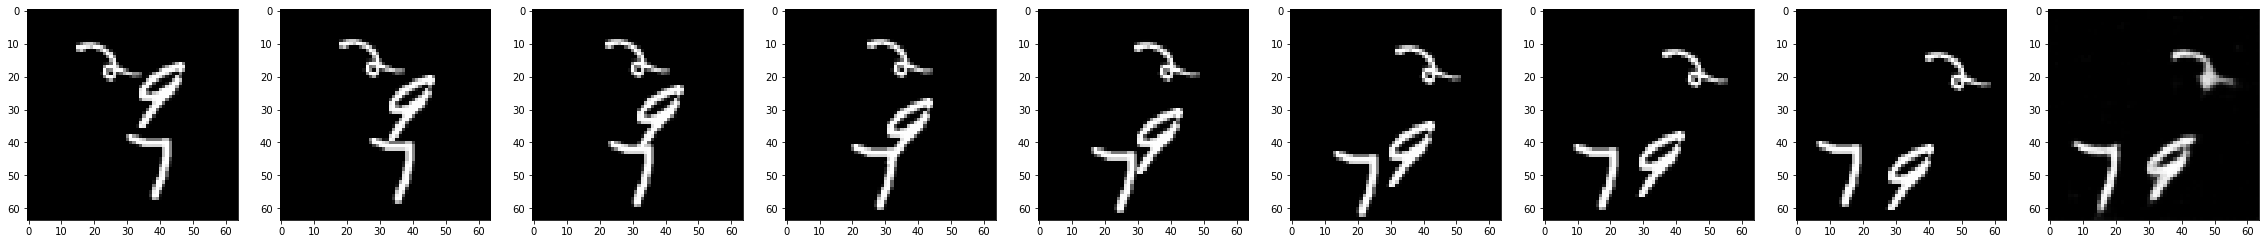

In [32]:
one = np.random.randint(len(test_dataset))
one = 3
x = test_dataset[one].to(device)
mask = torch.ones(x.shape).to(device)

input = torch.cat((x,mask),dim=1).unsqueeze(0)

y_origin = x
print(input.shape)
(pi, mu, sigma),predicts, imputation,latents = model(input)
predict = predicts[:,-1:,:,:]

# y_preds = [torch.normal(mu, sigma)[:, :, i, :] for i in range(n_gaussians)]

# y_preds=torch.sum((torch.normal(mu, sigma)*pi),dim=2)

# y_preds  = torch.normal(mu, sigma).gather(2,pi.max(2)[1].unsqueeze(2)).squeeze(2)

# pi_t=pi.transpose(2, 3)
# pi_t_r=pi_t.reshape(pi_t.size(0)*pi_t.size(1)*pi_t.size(2),pi_t.size(3))
# k = torch.multinomial(pi_t_r, 1).view(-1)
# k_r = k.reshape(pi_t.size(0),pi_t.size(1),pi_t.size(2)).unsqueeze(2)
# y_preds = torch.normal(mu, sigma).gather(2,k_r).squeeze(2)

# compare_result=torch.cat([x,y]+y_preds)
fig, axs = plt.subplots(1, 9,figsize=(40,90))


print(predict.sum())
axs[0].imshow(y_origin[0][0].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)
axs[1].imshow(y_origin[1][0].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)
axs[2].imshow(y_origin[2][0].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)
axs[3].imshow(y_origin[3][0].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)
axs[4].imshow(y_origin[4][0].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)
axs[5].imshow(y_origin[5][0].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)
axs[6].imshow(y_origin[6][0].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)
axs[7].imshow(y_origin[7][0].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)

axs[8].imshow(predict[0][0][0].detach().cpu().numpy(),cmap='gray', vmin=0, vmax=1)
print(((predict[0][0][0]-y_origin[2][0])**2).sum())

# for z_result in compare_result:
#     vae.decoder.eval()
#     with torch.no_grad():
#         d_image=vae.decoder(z_result)
#         plt.imshow(d_image.cpu().squeeze().numpy(), cmap='gray')
#         plt.show()

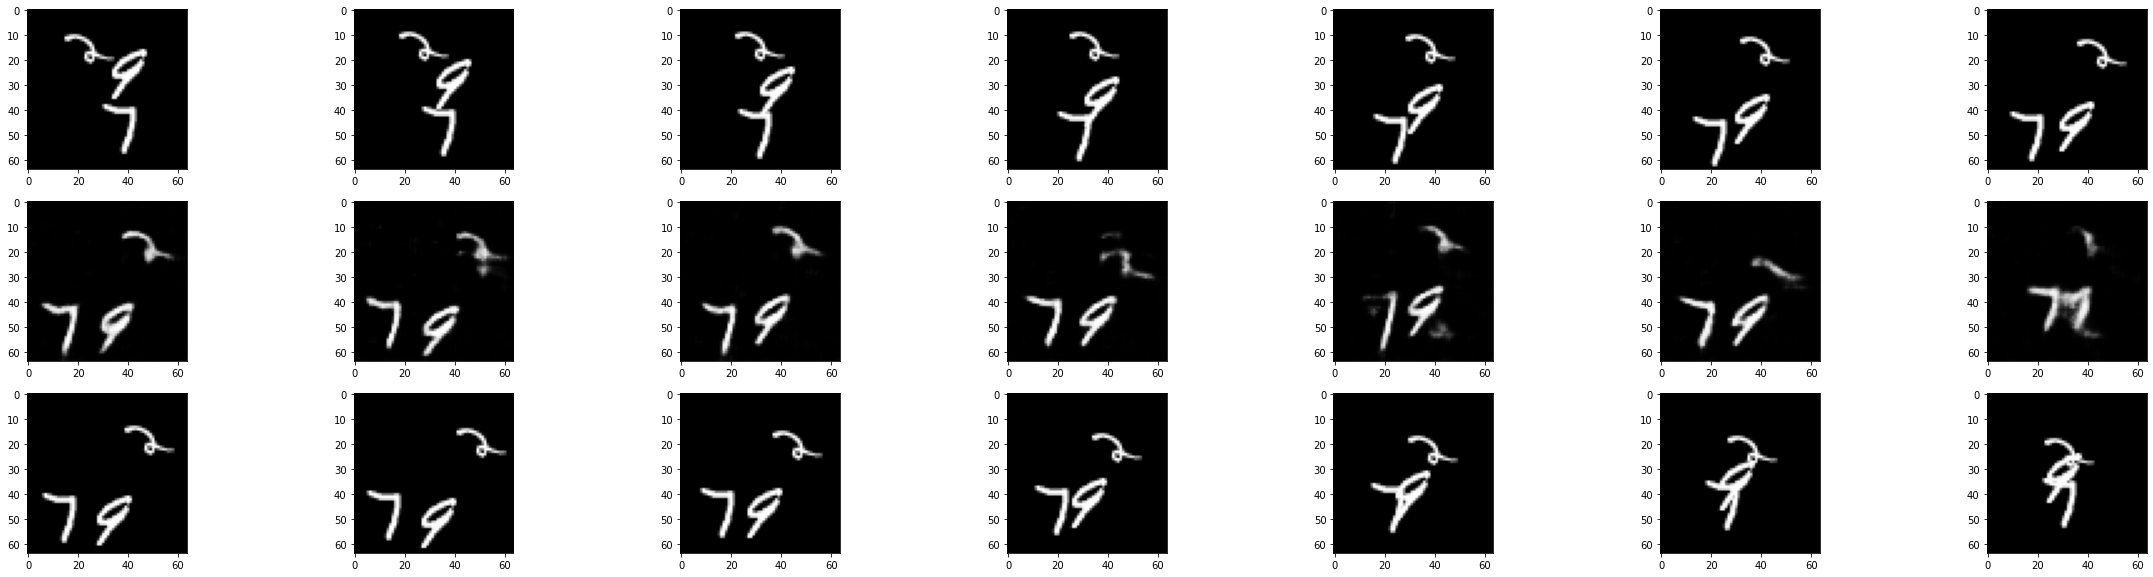

In [60]:
one = np.random.randint(len(test_dataset))
one = 3
x = test_dataset[one].to(device)
mask = torch.ones(x.shape).to(device)
predict_length = 7
predict_result = []
origin_input = x
for i in range(predict_length):
    input = torch.cat((x,mask),dim=1).unsqueeze(0)
   
    (pi, mu, sigma),predicts, imputation,latents = model(input)
    predict = predicts[:,-1:,:,:].squeeze(0)
    predict_result.append(predict)
    x = torch.cat([x[1:],predict])

fig, axs = plt.subplots(3, 7,figsize=(40,10))
for i in range(x.size(0)-1):
    axs[0,i].imshow(origin_input[i][0].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)

for j in range(len(predict_result)):
    
    axs[1,j].imshow(predict_result[j][0][0].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)

truth =torch.cat([origin_input[-1:], test_dataset[one+1][:predict_length].to(device)])

for k in range(x.size(0)-1):
    axs[2,k].imshow(truth[k][0].detach().cpu().numpy(),cmap='gray',vmin=0, vmax=1)





    


    

In [29]:
x = [0,1,2,3,4]

In [30]:
x[-2:-1]

[3]